# Inicialización de R

In [1]:
R.version.string

[1] "R version 4.0.4 (2021-02-15)"

## Instalación de paquetes

In [2]:
#install.packages("rgl", repos = "http://cran.rstudio.com/")

# Para hacer uso de distribucion normal multivariada
library("mvtnorm")

# Modelo de mezcla finita

Sea 
$$
D = \{x_1,. . . , x_N\}
$$ 
un conjunto de datos donde $x_i$ es un vector $d$-dimensional. Supongamos que los puntos se generan en forma I.I.D. a partir de una densidad subyacente $p(x)$. Suponemos además que $p(x)$ se define como un modelo de mezcla finita con $K$ componentes
$$
p(x | \Theta) = \sum_{k=1}^{K} \alpha_{k} p_k(x | z_{k}, \theta_{k})
$$
donde
* Los $p_k (x | z_k, \theta_k)$ son componentes de mezcla, $1 \leq k \leq K$. Cada uno es una densidad o distribución definida sobre $p (x)$, con parámetros $\theta_k$.

* $z = (z_1,..., z_K)$ es un vector de $K$ variables indicadoras binarias que son mutuamente excluyentes y exhaustivas (es decir, una y solo una de las $z_k$ es igual a 1, y las otras son 0). $z$ es una variable aleatoria $K$-aria que representa la identidad del componente de la mezcla que generó $x$. Es conveniente que los modelos mixtos representen un vector de $K$ variables indicadoras.

* Los $\alpha_k = p(z_k)$ son los pesos de la mezcla, que representan la probabilidad de que el componente $k$ genere una $x$ seleccionada al azar, donde

$$
\sum_{k = 1}^{K} \alpha_{k} = 1
$$

El conjunto completo de parámetros para un modelo de mezcla con componentes $K$ es

$$
\Theta = \{ \alpha_1, ... , \alpha_K, \theta_1, ... , \theta_K \}
$$

donde $\theta_k = \{ \mu_k, \Sigma_k \}$. Podemos calcular el peso del punto $x_i$ en el grupo $k$, dados los parámetros $\Theta$ como

$$
w_{ik} = p(z_{ik = 1 | x_i, \Theta}) = \frac{p_{k}(x_i|z_{k}, \theta_{k}) \cdot \alpha_{k}}{\sum_{m=1}^{K} p_{m}(x_i|z_{m}, \theta_{m}) \cdot \alpha_{m}}
$$

Los pesos de pertenencia anteriores reflejan nuestra incertidumbre, dados $x_i$ y $\Theta$, sobre cuál de los $K$ componentes generó el vector $x_i$. Tenga en cuenta que estamos asumiendo en nuestro modelo de mezcla generativa que cada $x_i$ fue generado por un solo componente, por lo que estas probabilidades reflejan nuestra incertidumbre sobre de qué componente proviene $x_i$, no cualquier "mezcla" en el proceso generativo.

# Conjunto de Datos
Nos limitamos al caso $d=2$ y $K = 2$ para simplificar visualización, y suponemos que $p_k \sim \mathcal{N}(\mu_{k}, \Sigma_{k})$ es decir, generamos datos de __Gaussianas Bivariadas__.
Generamos dos muestras de tamaño $N = 100$ con medias
$$
\mu_1 = (0,0), \mu_2 = (2,2)
$$
con matrices de covarianza
$$
\Sigma_{1} = \begin{bmatrix} 
    1 & 0\\
    0 & 1
\end{bmatrix}, \Sigma_{2} = \begin{bmatrix} 
    1.0 & 0.75\\
    0.75 & 1.0
\end{bmatrix}
$$

## Generacion de parámetros

In [3]:
# 0. Definimos tamanio de la muestra por clase, numero de clases y dimension
N <- 1000
K <- 2
d <- 2

In [4]:
# 1. Generamos medias de las dos muestras # PODEMOS GENERARLAS DE OTRA FORMA
mu_k <- c()
for(k in 1:K){
    mu <- rep(2.0, d) * (k-1)
    mu_k <- c(mu_k, mu)
}
dim(mu_k) <- c(d, K)
mu_k <- t(mu_k)

print("Medias")
print(mu_k)

[1] "Medias"
     [,1] [,2]
[1,]    0    0
[2,]    2    2


In [5]:
sigma_1 <- diag(d)
sigma_2 <- diag(d)
sigma_2[1,2] <- 0.75
sigma_2[2,1] <- 0.75

sigma_k <- c(sigma_1, sigma_2)
dim(sigma_k) <- c(K, d, d)

print("Sigmas")
print(sigma_k)

[1] "Sigmas"
, , 1

     [,1] [,2]
[1,]    1    0
[2,]    0    1

, , 2

     [,1] [,2]
[1,] 1.00 0.75
[2,] 0.75 1.00



In [6]:
# 2. Generamos ambas muestras # PODEMOS GENERARLAS DE OTRA FORMA, por ejemplo con mvnorm
set.seed(1)
X_1 <- rmvnorm(N, mean=mu_k[1,], sigma=sigma_k[,,1] )

set.seed(2)
X_2 <- rmvnorm(N, mean=mu_k[2,], sigma=sigma_k[,,2] )

X <- rbind(X_1, X_2)

# 3. Definimos nuestra matriz de muetras X y las etiquetas Y
Y <- c()
for(k in 1:K){
    Y <- c(Y, rep(1, N)*(k))
}

## Generación de datos

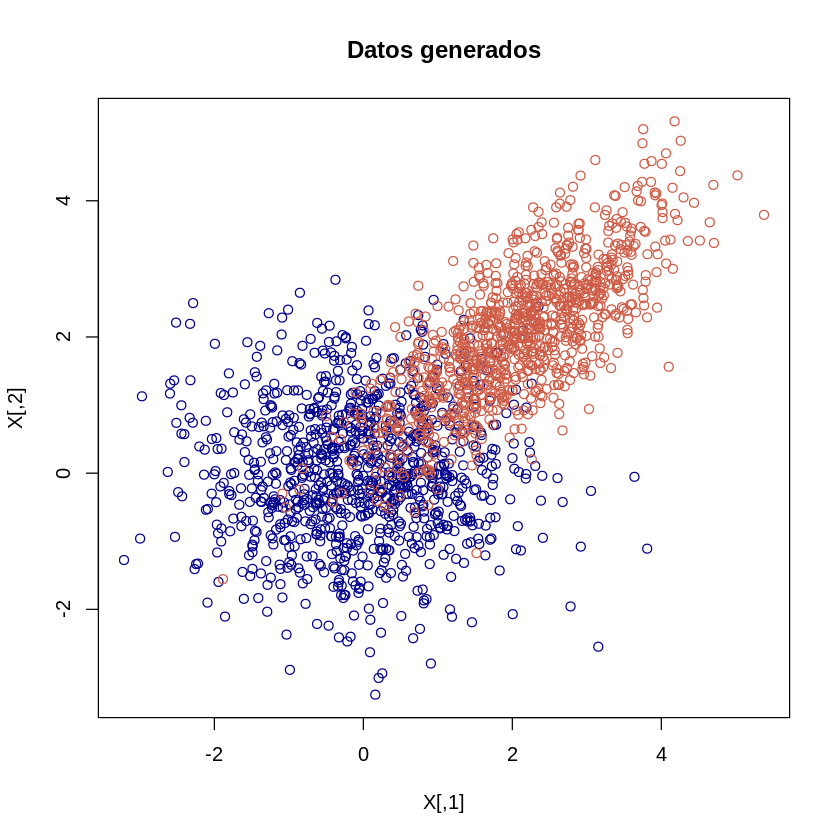

In [7]:
# 4. Generamos colores para cada clase y observamos los datos
cols <- c()
for(k in 1:K){
    cols <- c(cols, rep(colors()[30 * k], N))
}
plot(X, main="Datos generados", col=cols)

# EM (Expectation-Maximization)

Definimos el algoritmo __EM (Expectation-Maximization) para mezclas Gaussianas__ de la siguiente manera. El algoritmo es un algoritmo iterativo que comienza a partir de una estimación inicial $\Theta$ (por ejemplo, aleatorio), y luego procede a actualizar de forma iterativa $\Theta$ hasta que la convergencia. Cada iteración consta de un paso E y un paso M.

## E-Step
Denotamos los valores de los parámetros actuales como $\Theta$. Calculamos

$$
w_{ik} = p(z_{ik} = 1 | x_i, \Theta) = \frac{p_{k}(x_i|z_{k}, \theta_{k}) \cdot \alpha_{k}}{\sum_{m=1}^{K} p_{m}(x_i|z_{m}, \theta_{m}) \cdot \alpha_{m}}
$$

para todos los puntos de datos $x_i$, $1 \leq i \leq N$ y todos los componentes de la mezcla $1 \leq k \leq K$. Para cada punto de datos $x$ los pesos se definen de tal manera que $\sum_{k=1}^{K} w_{ik} = 1$. Esto produce una matriz $N \times K$ de pesos, donde cada una de las filas suma 1.

El resultado de este paso es una matriz $W$ de dimensiones $N \times K$.

In [8]:
e_step <- function(X, Theta){
    # 0. Obtenemos numero de datos y dimension de estos
    N <- dim(X)[1]
    d <- dim(X)[2]
    
    # 1. Separamos parametros
    alphas <- Theta[[1]]
    thetas <- Theta[[2]]
    K <- length(alphas)

    # 2. Llenamos matriz de pesos W
    W <- matrix(0.0, N, K)
    for(i in 1:N){
        x_i = X[i,]
        # 2.1 Calculamos prob_{ik} y denominador de la expresion para w_{ik}
        denominator <- 0.0
        for(k in 1:K){
            # Extraemos vector media y matriz de covarianza
            mu = thetas[[2*k - 1]]
            Sigma <- thetas[[2*k]]
            # Calculamos probabilidad
            p <- dmvnorm(
                x_i, mean = mu, sigma = Sigma, 
                log = FALSE, checkSymmetry = TRUE
            )
            # Calculamos peso w_{ik}
            W[i, k] <- alphas[k] * p
            # Terminando ciclo tendremos el denominador de la expresion
            denominator <- denominator + alphas[k] * p # "m = k"
        }
        W[i, ] <- W[i, ] * (1 / denominator)
    }
    
    return (W)
}

## M-Step
Ahora usamos los pesos y los datos para calcular nuevos valores de parámetros. Sea 
$$
N_k = \sum_{i=1}^{N} w_{ik}
$$
es decir, la suma de los pesos para el componente $k$ - este es el número efectivo de puntos de datos asignados al componente $k$.
Los nuevos pesos de mezcla son
$$
\alpha_{k}^{\text{new}} = \frac{N_{k}}{N} 
$$
La media actualizada se calcula de una manera similar a cómo podríamos calcular un promedio empírico estándar, excepto que el $i$-ésimo vector de datos $x_i$ tiene un valor de peso fraccional $w_{ik}$
$$
\mu_{k}^{\text{new}} = \frac{1}{N_k} \sum_{i=1}^{N} w_{ik} x_i
$$
Tenga en cuenta que esta es una ecuación vectorial ya que $\mu_{k}^{\text{new}}$ y $x_i$ son vectores $d$-dimensionales. 

Nuevamente obtenemos una ecuación que es similar en forma a cómo calcularíamos normalmente una matriz de covarianza empírica, excepto que la contribución de cada punto de datos está ponderada por $w_{ik}$. 
$$
\Sigma_{k}^{\text{new}} = \frac{1}{N_{k}}\sum_{i=1}^{N} w_{ik} (x_i - \mu_{k}^{\text{new}}) (x_i - \mu_{k}^{\text{new}})^{T}
$$
Tenga en cuenta que esta es una ecuación matricial de dimensionalidad $d \times d$ en cada lado.

Las ecuaciones en el M-Step deben calcularse en este orden, es decir, primero calcule los $K$ nuevos $\alpha$'s, luego los $K$ nuevos $\mu_k$'s y finalmente los $K$ nuevos $\Sigma_k$'s.

In [9]:
m_step <- function(X, W){
    # 0. Numero de datos, dimension de datos y numero de distribuciones
    N <- dim(X)[1]
    d <- dim(X)[2]
    K <- dim(W)[2]

    # 1. Calculamos los N_k descritos anteriormente
    N_k <- rep(0.0, K)
    for(k in 1:K){
        for(i in 1:N){
            N_k[k] <- N_k[k] + W[i,k]
        }
    }
    
    # 2. Calculamos nuevas \alpha's
    alpha_k <- N_k * (1 / N)

    # 3. Calculamos nuevas \mu's usando N_{k}, w_{i,k} y X_{i}
    mu_k <- matrix(0.0, K, d)
    for(k in 1:K){
        mu <- 0.0
        for(i in 1:N){
            mu <- mu + W[i,k] * X[i, ]
        }
        mu <- mu * 1 / N_k[k]
        mu_k[k,] <- mu
    }

    # 4. Calculamos \Sigma's
    sigma_k <- rep(diag(d), K)
    dim(sigma_k) <- c(K, d, d)
    for(k in 1:K){
        Sigma <- matrix(0.0, d, d)
        for(i in 1:N){
            Sigma <- Sigma + W[i,k] * ( (X[i,] - mu_k[k,]) %*% t( (X[i,] - mu_k[k,]) ) )
        }
        Sigma <- Sigma * (1 / N_k[k])
        sigma_k[,,k] <- Sigma
    }
    
    theta_1 <- list(mu_k[1,], sigma_k[,,1])
    theta_2 <- list(mu_k[2,], sigma_k[,,2])

    thetas <- c(theta_1,theta_2)
    if(K > 2){
        for(k in 3:K){
            theta_k <- list(mu_init[k,], sigma_init[,,k])
            thetas <- c(thetas, theta_k)
        }
    }

    Theta_new <- list(alpha_k, thetas)
    return (Theta_new)
}

Una vez que hayamos calculado todos los nuevos parámetros, el M-Step está completo y ahora podemos volver atrás y volver a calcular los pesos en el E-Step, luego volver a calcular los parámetros nuevamente en el E-Step y continuar actualizando los parámetros en este manera. Cada par de pasos E y M se considera una iteración.

## Funciones para condiciones de paro


### Función de Log-Verosimilitud
Usamos la funcion de Log-Verosimilitud para definir condiciones de paro. Cuando el cambio en esta funcion es suficientemente pequeño (menor que un $\epsilon > 0$) detenemos el algoritmo. La implementación devuelve -LogVerosimilitud por lo que se busca minimizar esta función.

In [10]:
loglikelihood <- function(X, Theta){
    N <- dim(X)[1]
    d <- dim(X)[2]
    
    alphas <- Theta[[1]]
    thetas <- Theta[[2]]
    K <- length(alphas)

    W <- matrix(0.0, N, K)
    for(i in 1:N){
        x_i = X[i,]
        for(k in 1:K){
            # Extraemos vector media y matriz de covarianza
            mu = thetas[[2*k - 1]]
            Sigma <- thetas[[2*k]]
            # Calculamos probabilidad
            p <- dmvnorm(
                x_i, mean = mu, sigma = Sigma, 
                log = FALSE, checkSymmetry = TRUE
            )
            # Calculamos peso w_{ik}
            W[i, k] <- alphas[k] * p
        }
    }
    loglikeli <- 0.0
    for(i in 1:N){
        loglikeli <- loglikeli + log(sum(W[i,]))
    }
    return (-loglikeli) # Retornamos el negativo para tener un problema de minimizacion
}

### Función para verificar convergencia
Usamos los siguientes criterios de convergencia
* Número máximo de iteraciones.
* Suficiente cambio en la funcion de logverosimilitud.

In [11]:
convergence <- function(X, Theta, epoch, epochs, eps, likeli_prev, likeli_act){
    # Args
    #   Theta (list): Lista de parámetros {\alpha_1,...,\alpha_K, theta_1,...,\theta_K}
    #   epoch (int): Iteracion/epoca actual
    #   epochs (int): Numero de iteraciones/epocas para criterio de convergencia

    # Si el numero de iteraciones es mayor que una cota o 
    # Si el valor de logverosimilitud no cambia lo suficiente 
    # Entonces se cumple criterio de convergencia
    if( epoch >= epochs || abs(likeli_prev - likeli_act) < eps ) 
        return (TRUE)
    return (FALSE)
}

## Función principal
La función correspondiente al algoritmo descrito al inicio de esta sección.

In [12]:
EM <- function(X, Theta, epochs, eps=0.01){
    # Args
    #   X (Matriz o Dataframe de dimension N x d): Matriz de datos
    #   Theta (list): Lista de parámetros {\alpha_1,...,\alpha_K, theta_1,...,\theta_K}
    #   epochs (int): Numero de iteraciones/epocas para criterio de convergencia
    epoch <- 1
    likeli_k <- c(-1.0, loglikelihood(X, Theta)) # Primer likeli no cuenta
    while( !convergence(X, Theta, epoch, epochs, eps, likeli_k[epoch],likeli_k[epoch + 1]) ){
        # Obtenemos matriz de probabilidades W=[w_{ik}]=P(x|)
        W <- e_step(X, Theta)
        Theta_new <- m_step(X, W)
        Theta <- Theta_new
        
        epoch <- epoch + 1
        # Calculamos verosimilitud
        likeli_k <- c(likeli_k, loglikelihood(X, Theta))
    }
    print("Numero de iteraciones")
    print(epoch)
    
    print("Grafica Iteracion vs Log-Verosimilitud")
    plot(1:epoch,likeli_k[-1])
    
    return (Theta)
}

# Definción de parámetros iniciales del método __EM__

## Parámetros iniciales aleatorios

### Cálculo de parámetros iniciales
* Inicializamos $\alpha_k$, suponemos la probabilidad de que el dato provenga de la componente $k$ es igual para toda $k$ en $[1:K]$.
* Inicializamos $\mu_{k}$'s a partir de una normal centrada en $(0,0)$ con covarianza $5 \cdot I_{d \times d}$.
* Generamos las matrices de covarianza $\Sigma_{k}$, por simplicidad suponemos cada una como $I_{d \times d}$.


In [13]:
# 1. Definimos \alpha's, suponemos la probabilidad de que el dato provenga de 
#    la componente k es igual para toda k en [1:K].
alphas <- rep(1.0, K) * 1/K

print("Alphas")
print(alphas)

[1] "Alphas"
[1] 0.5 0.5


In [14]:
# 2. Generamos medias iniciales a partir de una Gaussiana centrada en (1,1).
set.seed(123)
mu_init <- rmvnorm(K, mean=rep(1.0, d), sigma=diag(d)*5.0)

print("Medias iniciales")
print(mu_init)

[1] "Medias iniciales"
           [,1]      [,2]
[1,] -0.2532616 0.4853075
[2,]  4.4853777 1.1576616


In [15]:
# 3. Generamos las matrices de covarianza, por simplicidad suponemos matriz Id
sigma_init <- rep(diag(d), K)
dim(sigma_init) <- c(K, d, d)

print("Matrices de covarianza iniciales")
print(sigma_init)

[1] "Matrices de covarianza iniciales"
, , 1

     [,1] [,2]
[1,]    1    0
[2,]    0    1

, , 2

     [,1] [,2]
[1,]    1    0
[2,]    0    1



In [16]:
# 4. Unimos parametros en un lista \theta_k para identificar con la notacion
theta_1 <- list(mu_init[1,], sigma_init[,,1])
theta_2 <- list(mu_init[2,], sigma_init[,,2])

thetas <- c(theta_1,theta_2)
if(K > 2){
    for(k in 3:K){
        theta_k <- list(mu_init[k,], sigma_init[,,k])
        thetas <- c(thetas, theta_k)
    }
}

print("Parametros iniciales de K Gaussianas")
print(thetas)

[1] "Parametros iniciales de K Gaussianas"
[[1]]
[1] -0.2532616  0.4853075

[[2]]
     [,1] [,2]
[1,]    1    0
[2,]    0    1

[[3]]
[1] 4.485378 1.157662

[[4]]
     [,1] [,2]
[1,]    1    0
[2,]    0    1



[1] "Parametros iniciales del metodo EM (Theta)"
[[1]]
[1] 0.5 0.5

[[2]]
[[2]][[1]]
[1] -0.2532616  0.4853075

[[2]][[2]]
     [,1] [,2]
[1,]    1    0
[2,]    0    1

[[2]][[3]]
[1] 4.485378 1.157662

[[2]][[4]]
     [,1] [,2]
[1,]    1    0
[2,]    0    1




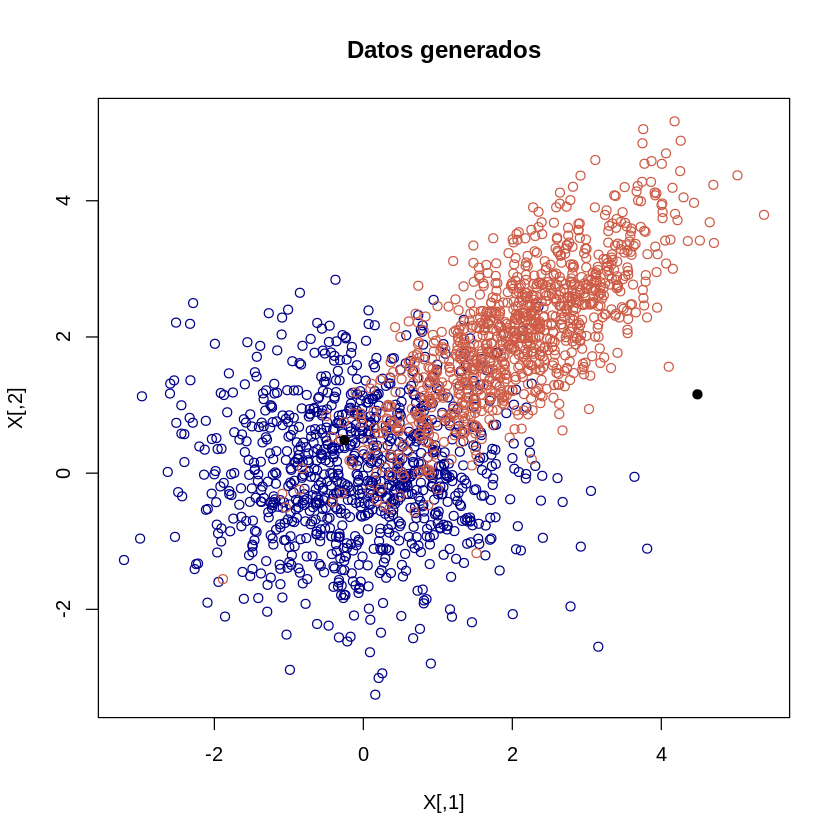

In [17]:
Theta <- list(alphas, thetas)

print("Parametros iniciales del metodo EM (Theta)")
print(Theta) #print(Theta[2][[1]][1])

plot(X, main="Datos generados", col=cols)
points( c(Theta[[2]][[1]][1]), c(Theta[[2]][[1]][2]), col="black", pch=19 )
points( c(Theta[[2]][[3]][1]), c(Theta[[2]][[3]][2]), col="black", pch=19 )

### Cálculo de resultados de EM

[1] "Numero de iteraciones"
[1] 40
[1] "Grafica Iteracion vs Log-Verosimilitud"


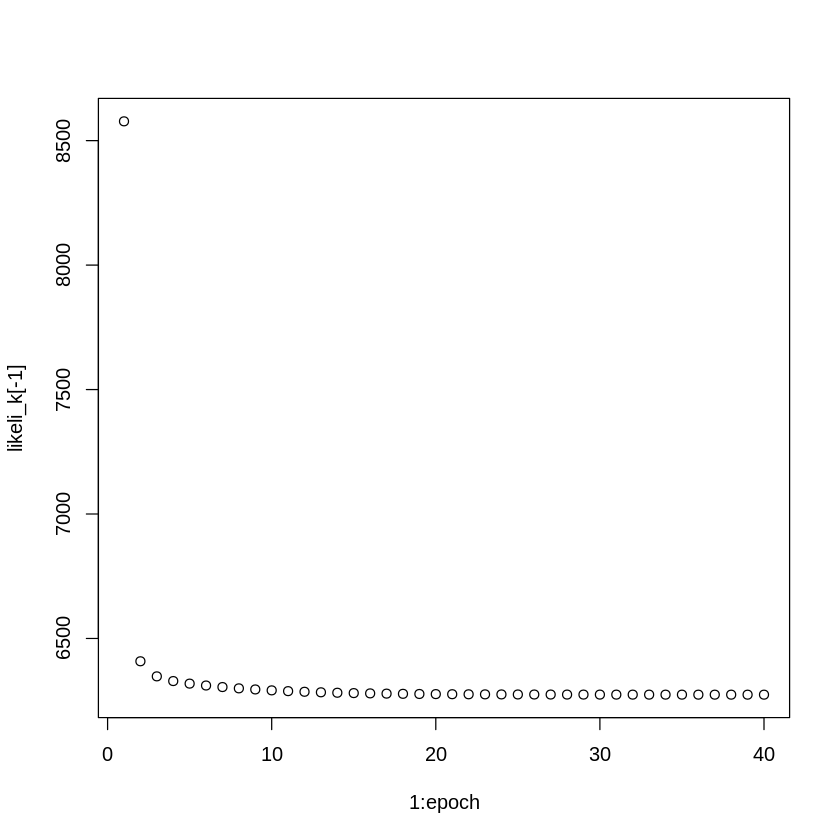

In [18]:
Theta_opt <- EM(X, Theta, 100)

[1] "Resultado del metodo EM (Inicializado Aleatorio)"
[1] "--------------------------------------------------"
[1] "alphas:"
[1] 0.5068009 0.4931991
[1] "--------------------------------------------------"
[1] "thetas:"
[1] "Mu_k Calculadas"
            [,1]       [,2]
[1,] -0.03834089 0.02409641
[2,]  2.09376323 2.05907230
[1] "Sigma_k Calculadas"
            [,1]        [,2]
[1,] 1.144435550 0.009396527
[2,] 0.009396527 1.005794513
[3,] 0.976221071 0.730373418
[4,] 0.730373418 0.982062529
[1] "--------------------------------------------------"
[1] "Parametros originales"
[1] "Mu_k"
     [,1] [,2]
[1,]    0    0
[2,]    2    2
[1] "Sigma_k"
, , 1

     [,1] [,2]
[1,]    1    0
[2,]    0    1

, , 2

     [,1] [,2]
[1,] 1.00 0.75
[2,] 0.75 1.00

[1] "--------------------------------------------------"


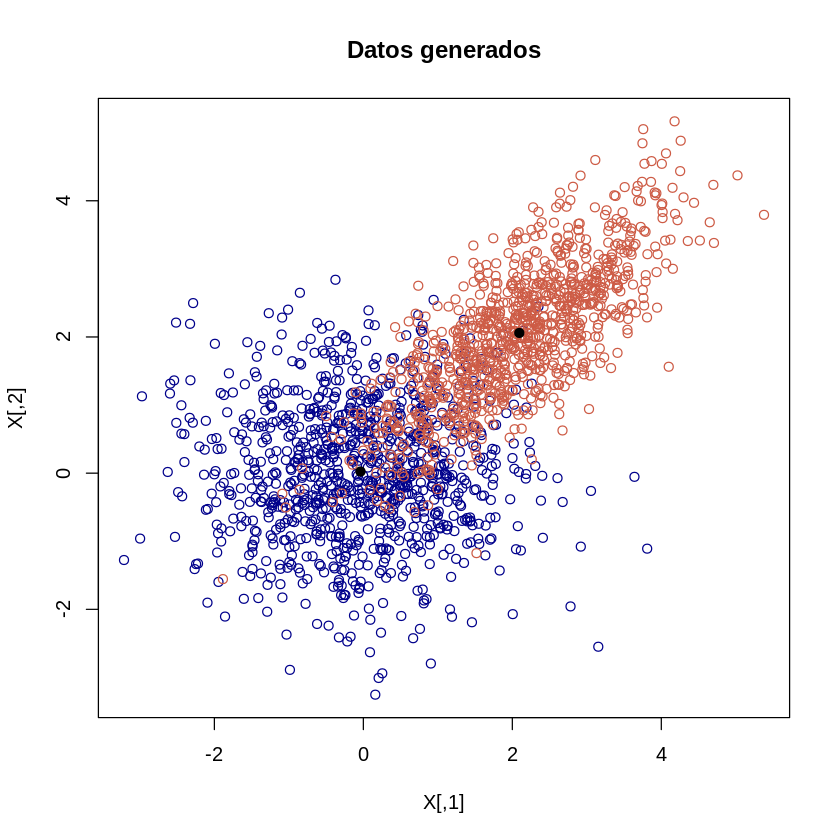

In [19]:
print("Resultado del metodo EM (Inicializado Aleatorio)")
print("--------------------------------------------------")
print("alphas:")
print(Theta_opt[[1]])


print("--------------------------------------------------")
print("thetas:")
mu_opt <- rbind(Theta_opt[[2]][[1]], Theta_opt[[2]][[3]])
sigma_opt <- rbind(Theta_opt[[2]][[2]], Theta_opt[[2]][[4]])

print("Mu_k Calculadas")
print(mu_opt)

print("Sigma_k Calculadas")
print(sigma_opt)

print("--------------------------------------------------")
print("Parametros originales")
print("Mu_k")
print(mu_k)
print("Sigma_k")
print(sigma_k)

print("--------------------------------------------------")
plot(X, main="Datos generados", col=cols)
points( c(Theta_opt[[2]][[1]][1]), c(Theta_opt[[2]][[1]][2]), col="black", pch=19 )
points( c(Theta_opt[[2]][[3]][1]), c(Theta_opt[[2]][[3]][2]), col="black", pch=19 )

## Inicialización de parametros con K-medias.

### Calculo de parametros iniciales

In [20]:
# 1. Clusterizamos con K-means.
set.seed(123)
km <- kmeans(X, K)

In [21]:
# 2. Obtenemos alphas iniciales con los pesos calculados con kmeans
alphas <- km$withinss * (1 / (2*N))

print("Alphas")
print(alphas)

[1] "Alphas"
[1] 1.0525011 0.6171417


In [22]:
# 3. Usamos medias encontradas por kmeans
mu_init <- km$centers

print("Medias iniciales")
print(mu_init)

[1] "Medias iniciales"
         [,1]       [,2]
1 -0.01438796 0.05345115
2  2.32372084 2.27027357


In [23]:
# 2. Calculamos matrices de covarianza a partir de los clusters dados por kmeans
sigma_init <- rep(diag(d), K)
dim(sigma_init) <- c(K, d, d)

for(k in 1:K){
    sigma_init[,,k] <- cov(X[km$cluster == k,])
}

print("Matrices de covarianza iniciales")
print(sigma_init)

[1] "Matrices de covarianza iniciales"
, , 1

            [,1]        [,2]
[1,] 0.982744564 0.003822575
[2,] 0.003822575 0.896721733

, , 2

          [,1]      [,2]
[1,] 0.6849968 0.3884149
[2,] 0.3884149 0.7207929



In [24]:
# 3. Unimos parametros en un lista \theta_k para identificar con la notacion
theta_1 <- list(mu_init[1,], sigma_init[,,1])
theta_2 <- list(mu_init[2,], sigma_init[,,2])

thetas <- c(theta_1,theta_2)
if(K > 2){
    for(k in 3:K){
        theta_k <- list(mu_init[k,], sigma_init[,,k])
        thetas <- c(thetas, theta_k)
    }
}

print("Parametros iniciales de K Gaussianas")
print(thetas)

[1] "Parametros iniciales de K Gaussianas"
[[1]]
[1] -0.01438796  0.05345115

[[2]]
            [,1]        [,2]
[1,] 0.982744564 0.003822575
[2,] 0.003822575 0.896721733

[[3]]
[1] 2.323721 2.270274

[[4]]
          [,1]      [,2]
[1,] 0.6849968 0.3884149
[2,] 0.3884149 0.7207929



[1] "Parametros iniciales del metodo EM (Theta)"
[[1]]
[1] 1.0525011 0.6171417

[[2]]
[[2]][[1]]
[1] -0.01438796  0.05345115

[[2]][[2]]
            [,1]        [,2]
[1,] 0.982744564 0.003822575
[2,] 0.003822575 0.896721733

[[2]][[3]]
[1] 2.323721 2.270274

[[2]][[4]]
          [,1]      [,2]
[1,] 0.6849968 0.3884149
[2,] 0.3884149 0.7207929




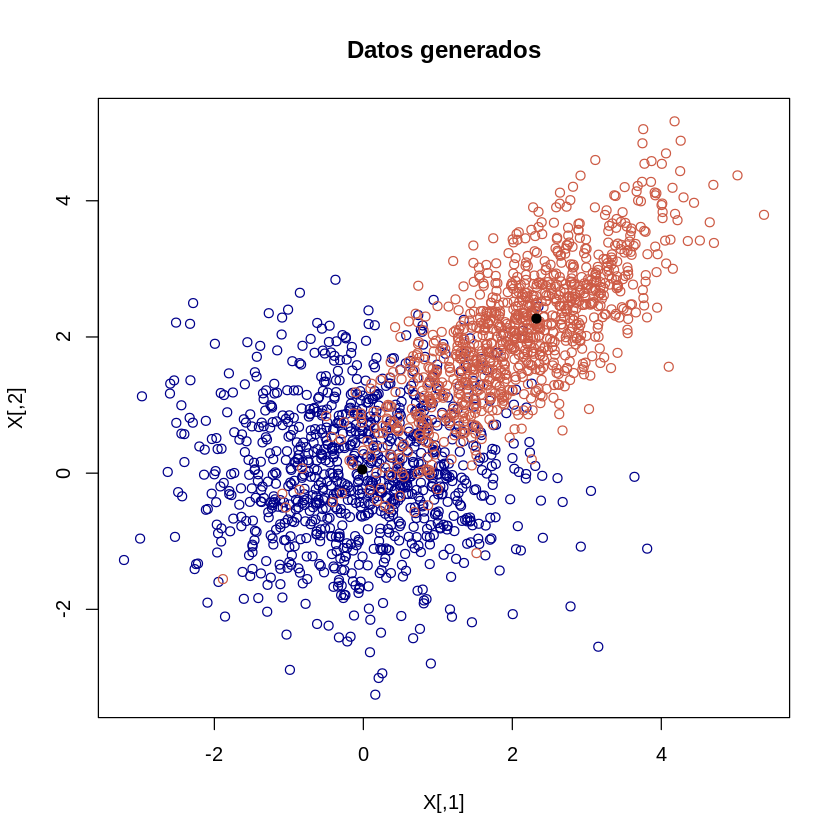

In [25]:
Theta <- list(alphas, thetas)

print("Parametros iniciales del metodo EM (Theta)")
print(Theta) #print(Theta[2][[1]][1])

plot(X, main="Datos generados", col=cols)
points( c(Theta[[2]][[1]][1]), c(Theta[[2]][[1]][2]), col="black", pch=19 )
points( c(Theta[[2]][[3]][1]), c(Theta[[2]][[3]][2]), col="black", pch=19 )

### Cálculo de resultados de EM

[1] "Numero de iteraciones"
[1] 10
[1] "Grafica Iteracion vs Log-Verosimilitud"


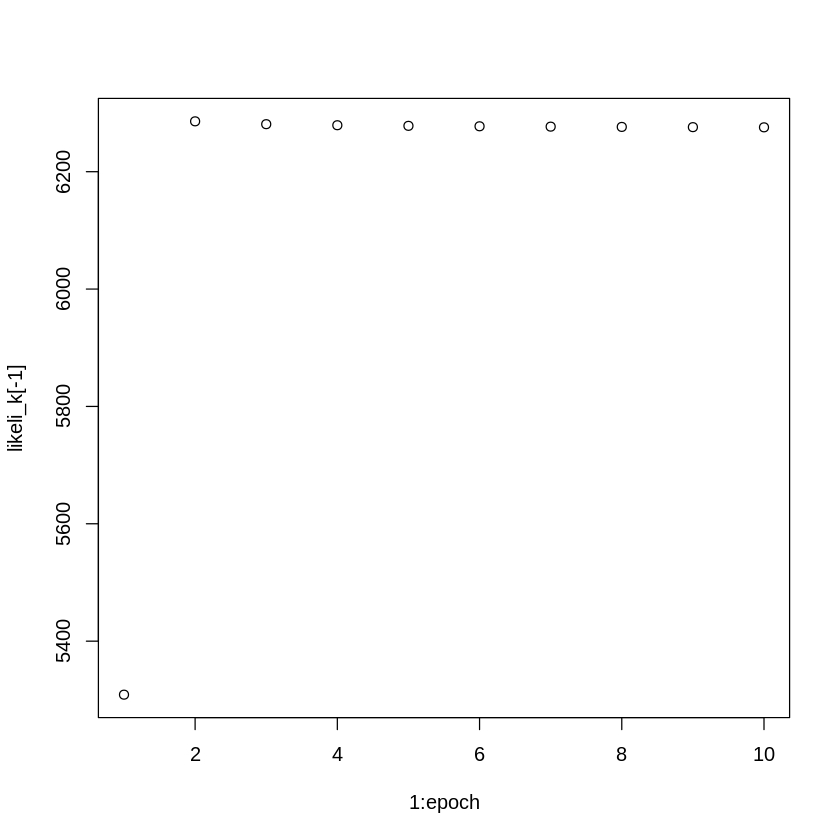

In [26]:
Theta_opt <- EM(X, Theta, 10)

[1] "Resultado del metodo EM (Inicializado Aleatorio)"
[1] "--------------------------------------------------"
[1] "alphas:"
[1] 0.533393 0.466607
[1] "--------------------------------------------------"
[1] "thetas:"
[1] "Mu_k Calculadas"
            [,1]       [,2]
[1,] 0.004900674 0.06259929
[2,] 2.165841743 2.13103238
[1] "Sigma_k Calculadas"
           [,1]       [,2]
[1,] 1.15290490 0.05333096
[2,] 0.05333096 1.01328295
[3,] 0.90133280 0.66131337
[4,] 0.66131337 0.90840697
[1] "--------------------------------------------------"
[1] "Parametros originales"
[1] "Mu_k"
     [,1] [,2]
[1,]    0    0
[2,]    2    2
[1] "Sigma_k"
, , 1

     [,1] [,2]
[1,]    1    0
[2,]    0    1

, , 2

     [,1] [,2]
[1,] 1.00 0.75
[2,] 0.75 1.00

[1] "--------------------------------------------------"


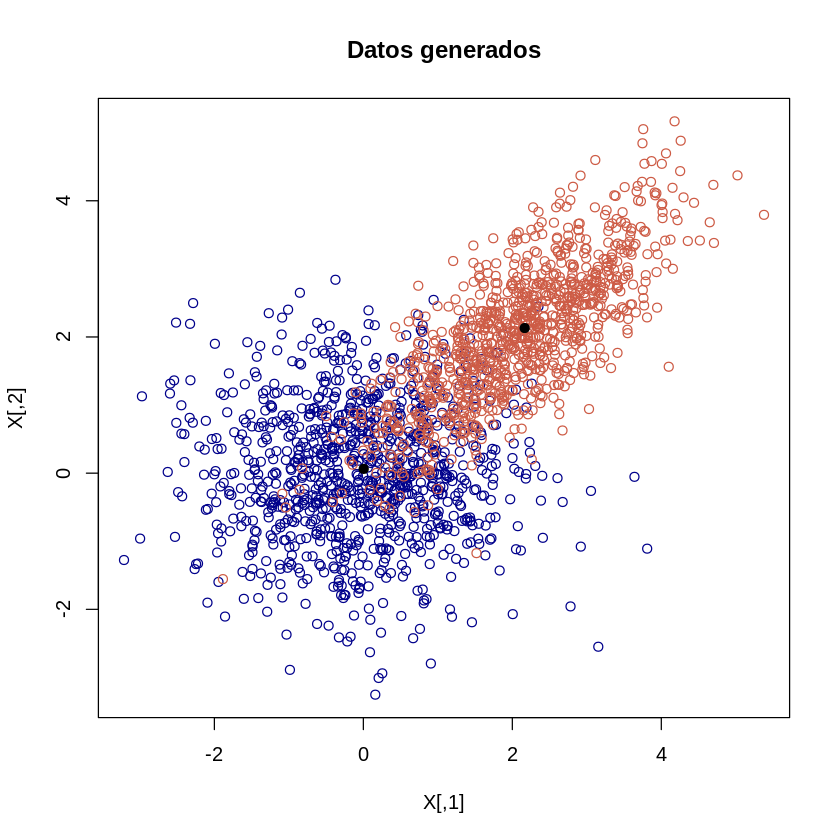

In [27]:
print("Resultado del metodo EM (Inicializado Aleatorio)")
print("--------------------------------------------------")
print("alphas:")
print(Theta_opt[[1]])


print("--------------------------------------------------")
print("thetas:")
mu_opt <- rbind(Theta_opt[[2]][[1]], Theta_opt[[2]][[3]])
sigma_opt <- rbind(Theta_opt[[2]][[2]], Theta_opt[[2]][[4]])

print("Mu_k Calculadas")
print(mu_opt)

print("Sigma_k Calculadas")
print(sigma_opt)

print("--------------------------------------------------")
print("Parametros originales")
print("Mu_k")
print(mu_k)
print("Sigma_k")
print(sigma_k)

print("--------------------------------------------------")
plot(X, main="Datos generados", col=cols)
points( c(Theta_opt[[2]][[1]][1]), c(Theta_opt[[2]][[1]][2]), col="black", pch=19 )
points( c(Theta_opt[[2]][[3]][1]), c(Theta_opt[[2]][[3]][2]), col="black", pch=19 )

# Conclusiones

Podemos notar que el método logra aproximar bien las distribuciones en ambos casos: 

* Inicialización aleatória de parámetros.
* Inicialización de parámetros con $K-$Medias. 

Comparando ambas inicializaciones podemos notar que la inicialización con $K-$Medias alcanza la convergencia en un número menor de iteraciones. Por otro lado, buscamos minimizar la funcion -logVerosimilitud y en los experimentos observamos que la inicialización con las medias $\mu_k$ de $K-$Medias con $\Sigma_k = I_{d \times d}$ logró un valor de -logVerosimilitud menor que el valor obtenido con los parámetros encontrados por el método EM. 

# Referencias
* Notas del curso
* https://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf